### Analysis of PAR-2 membrane association in polarised vs uniform cells

Context:
- Comparing membrane to cytoplasmic ratio in polarised vs uniform cells to assess cooperative membrane association

Results:
- For wild type PAR-2, affinity is higher in polarised cells, implying nonlinear membrane association kinetics
- For RING mutants (C56S, L109R), this difference is lost

Dependencies:
- Relies on quantification data generated using the _Run/par2_nebd_quantify.ipynb_ notebook   


In [1]:
import glob
import os

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from matplotlib.legend_handler import HandlerTuple

from src import (
    add_stats_table_row,
    bootstrap_effect_size_pd,
    bounded_mean_1d,
    dataplot,
    lighten,
    load_image,
    nb_setup,
    raw_data_path,
    rotated_embryo,
    save_img,
)

nb_setup()
os.makedirs("Figs", exist_ok=True)
os.makedirs("../../../data/EMBO_source_data", exist_ok=True)

%matplotlib inline

### Quantification

In [2]:
# Import data
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")

# Filter relevant data
lines = ["lp637", "nwg201", "nwg240", "nwg246", "nwg338", "nwg369"]
df = df[df.Line.isin(lines) & (df.RNAi == "wt")]
df_quantification = df_quantification[df_quantification.EmbryoID.isin(df.EmbryoID)]


# Summary quantification
def calculate_summary(group):
    cyt = group["Cytoplasmic signal"].mean()
    mem_tot = group["Membrane signal"].mean()
    mem_ant = bounded_mean_1d(group["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(group["Membrane signal"], [0.9, 0.1])
    ratio_post = mem_post / cyt
    return pd.Series(
        {
            "Cyt": cyt,
            "Mem_tot": mem_tot,
            "Mem_ant": mem_ant,
            "Mem_post": mem_post,
            "Ratio post": ratio_post,
        }
    )


df_summary = df_quantification.groupby("EmbryoID").apply(calculate_summary)
df = pd.merge(df, df_summary, on="EmbryoID")

# Add columns
df["UniPol"] = df.Line.apply(
    lambda x: "Pol" if x in ["lp637", "nwg240", "nwg338"] else "Uni"
)
df["Genotype"] = df.Line.apply(
    lambda x: "WT"
    if x in ["lp637", "nwg201"]
    else "C56S"
    if x in ["nwg240", "nwg246"]
    else "L109R"
)

### Plot: WT vs C56S quantification

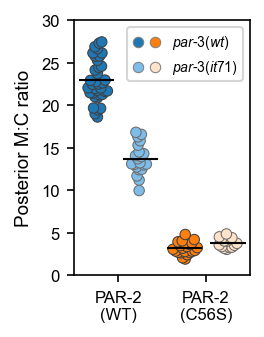

In [3]:
# Filter data
_df = df[df.Line.isin(["lp637", "nwg201", "nwg240", "nwg246"])]

# Set up figure
fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# Colour palettes
palette1 = {"WT": "tab:blue", "C56S": "tab:orange"}
palette2 = {_: lighten(__, 1.7) for _, __ in palette1.items()}
order = ["WT", "C56S"]

# Plot polarised data
dataplot(
    data=_df[_df.UniPol == "Pol"],
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette1,
    transform=trans + offset(-10),
    linewidth=0.5,
    offset=-0.25,
)

# Plot uniform data
dataplot(
    data=_df[_df.UniPol == "Uni"],
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette2,
    transform=trans + offset(10),
    linewidth=0.5,
    offset=0.25,
)

# Legend
s = 25
top_left = ax.scatter([], [], linewidth=0.5, edgecolors="gray", color="tab:blue", s=s)
top_right = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color="tab:orange", s=s
)
bottom_left = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color=lighten("tab:blue", 1.7), s=s
)
bottom_right = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color=lighten("tab:orange", 1.7), s=s
)
ax.legend(
    [(top_left, top_right), (bottom_left, bottom_right)],
    [r"$par$" + "-" + r"$3(wt)$", r"$par$" + "-" + r"$3(it71)$"],
    fontsize=6.7,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)

# Finalise plot
ax.set_xticklabels(["PAR-2\n(WT)", "PAR-2\n(C56S)"])
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0, 30)
ax.set_ylabel("Posterior M:C ratio", fontsize=9)
fig.set_size_inches(1.8, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.2)

# Save figure
fig.savefig("Figs/mc_ratio.png", dpi=600, transparent=True)
fig.savefig("Figs/mc_ratio.pdf", transparent=True)

# SourceData
_df.to_csv("../../../data/EMBO_source_data/1E.csv", index=False)

In [4]:
# Effect of uniform vs polarised for wt data
es, pr, ss = bootstrap_effect_size_pd(
    data=_df[_df.Genotype == "WT"], x="UniPol", y="Ratio post", a="Pol", b="Uni"
)
add_stats_table_row(
    figure="1",
    panel="E",
    sample_a="PAR-2(WT); par-3(wt)",
    sample_b="PAR-2(WT); par-3(it71)",
    measure="Posterior M:C ratio (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="bPBbMV2LIL",
)

# Effect of uniform vs polarised for C56S data
es, pr, ss = bootstrap_effect_size_pd(
    data=_df[_df.Genotype == "C56S"], x="UniPol", y="Ratio post", a="Pol", b="Uni"
)
add_stats_table_row(
    figure="1",
    panel="E",
    sample_a="PAR-2(C56S); par-3(wt)",
    sample_b="PAR-2(C56S); par-3(it71)",
    measure="Posterior M:C ratio (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="HS6YU5pQ5U",
)

### Images: WT vs C56S (Raw/SAIBR composite)

/app/src/../raw_data//Imaging/par2_nebd/200129_lp637_wt_tom4,15,60/15,30_
/app/src/../raw_data//Imaging/par2_nebd/200131_nwg201_wt_tom4,15,60/18
/app/src/../raw_data//Imaging/par2_nebd/210428_nwg240_tom4,15,60/05
/app/src/../raw_data//Imaging/par2_nebd/200129_nwg246_wt_tom4,15,60/00


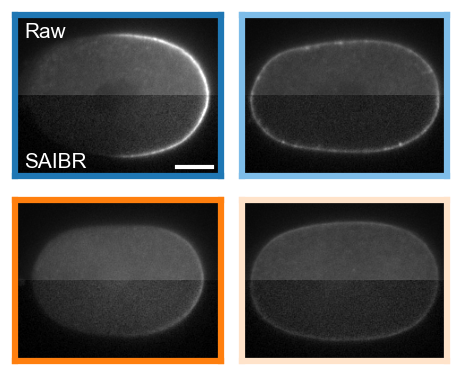

In [5]:
def load_data(path):
    roi = np.loadtxt(path + "/ROI_fit.txt")
    img_af_corrected = load_image(path + "/af_corrected.tif")
    img_raw = load_image(glob.glob(path + "/*488 SP 535-50*.TIF")[0])
    return roi, img_af_corrected, img_raw


def plot_image_panel(ax, path, color, scale_bar=False):
    # Load data
    roi, img1, img2 = load_data(path)

    # Rotate
    rotated1 = rotated_embryo(img1, roi, 230, 180, 3)
    rotated2 = rotated_embryo(img2, roi, 230, 180, 3)

    # Plot composide image
    mask1 = np.concatenate((np.ones([90, 230]), np.zeros([90, 230])), axis=0)
    mask2 = np.concatenate((np.zeros([90, 230]), np.ones([90, 230])), axis=0)
    ax.imshow(rotated2, cmap="gray", vmin=0, vmax=40866.22508001195, alpha=mask1)
    ax.imshow(rotated1, cmap="gray", vmin=0, vmax=33648.54240741733, alpha=mask2)

    # Format figure
    ax.set_xticks([])
    ax.set_yticks([])
    [spine.set_edgecolor(color) for spine in ax.spines.values()]
    [spine.set_linewidth(3) for spine in ax.spines.values()]

    # Scale bar and annotations
    if scale_bar:
        px = 0.255  # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated1.shape[0] - 10
        ax.plot(
            [rotated1.shape[1] - 10 - bar_pixels, rotated1.shape[1] - 10],
            [y, y],
            color="w",
            linewidth=2,
        )
        ax.text(s="Raw", x=10, y=25, c="w", fontsize=10)
        ax.text(s="SAIBR", x=10, y=170, c="w", fontsize=10)


if raw_data_path:
    # Paths
    path_wt_pol = (
        raw_data_path + df[(df.Genotype == "WT") * (df.UniPol == "Pol")].Path.iloc[0]
    )
    path_wt_uni = (
        raw_data_path + df[(df.Genotype == "WT") * (df.UniPol == "Uni")].Path.iloc[0]
    )
    path_c56s_pol = (
        raw_data_path + df[(df.Genotype == "C56S") * (df.UniPol == "Pol")].Path.iloc[0]
    )
    path_c56s_uni = (
        raw_data_path + df[(df.Genotype == "C56S") * (df.UniPol == "Uni")].Path.iloc[0]
    )
    print(path_wt_pol)
    print(path_wt_uni)
    print(path_c56s_pol)
    print(path_c56s_uni)

    # Create figure
    fig, ax = plt.subplots(2, 2)
    conditions = {
        "WT_Pol": {"path": path_wt_pol, "color": "tab:blue", "scale_bar": True},
        "WT_Uni": {
            "path": path_wt_uni,
            "color": lighten("tab:blue", 1.7),
            "scale_bar": False,
        },
        "C56S_Pol": {"path": path_c56s_pol, "color": "tab:orange", "scale_bar": False},
        "C56S_Uni": {
            "path": path_c56s_uni,
            "color": lighten("tab:orange", 1.7),
            "scale_bar": False,
        },
    }
    for i, condition in enumerate(conditions.values()):
        plot_image_panel(ax[i // 2][i % 2], **condition)

    # Format figure
    fig.set_size_inches(4, 3)
    fig.subplots_adjust(wspace=-0.05, hspace=0.15)

    # Save figure
    fig.savefig("Figs/embryos_composite.png", dpi=600, transparent=True)
    fig.savefig("Figs/embryos_composite.pdf", transparent=True)

    # SourceData
    os.makedirs("../../../data/EMBO_source_data/1D", exist_ok=True)
    for condition_name, condition in conditions.items():
        _, img1, img2 = load_data(condition["path"])
        save_img(
            img1, f"../../../data/EMBO_source_data/1D/{condition_name}_af_corrected.tif"
        )
        save_img(img2, f"../../../data/EMBO_source_data/1D/{condition_name}_raw.tif")

### Plot: WT vs L109R quantification

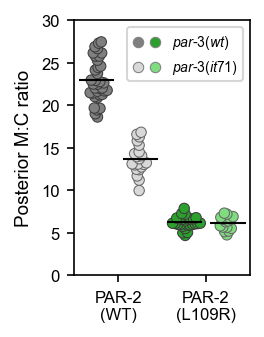

In [6]:
# Filter data
_df = df[df.Line.isin(["lp637", "nwg201", "nwg338", "nwg369"])]

# Colour palettes
palette1 = {"WT": "tab:gray", "L109R": "tab:green"}
palette2 = {_: lighten(__, 1.7) for _, __ in palette1.items()}
order = ["WT", "L109R"]

# Set up figure
fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

dataplot(
    data=_df[_df.UniPol == "Pol"],
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette1,
    transform=trans + offset(-10),
    linewidth=0.5,
    offset=-0.25,
)
dataplot(
    data=_df[_df.UniPol == "Uni"],
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette2,
    transform=trans + offset(10),
    linewidth=0.5,
    offset=0.25,
)

# Legend
s = 25
top_left = ax.scatter([], [], linewidth=0.5, edgecolors="gray", color="tab:gray", s=s)
top_right = ax.scatter([], [], linewidth=0.5, edgecolors="gray", color="tab:green", s=s)
bottom_left = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color=lighten("tab:gray", 1.7), s=s
)
bottom_right = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color=lighten("tab:green", 1.7), s=s
)
ax.legend(
    [(top_left, top_right), (bottom_left, bottom_right)],
    [r"$par$" + "-" + r"$3(wt)$", r"$par$" + "-" + r"$3(it71)$"],
    fontsize=6.7,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)

ax.set_xticklabels(["PAR-2\n(WT)", "PAR-2\n(L109R)"])
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0, 30)
ax.set_ylabel("Posterior M:C ratio", fontsize=9)
fig.set_size_inches(1.8, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.2)

# Save figure
fig.savefig("Figs/mc_ratio_l109r.png", dpi=600, transparent=True)
fig.savefig("Figs/mc_ratio_l109r.pdf", transparent=True)

# SourceData
_df.to_csv("../../../data/EMBO_source_data/2I.csv", index=False)

In [7]:
# Effect of uniform vs polarised for L109R data
es, pr, ss = bootstrap_effect_size_pd(
    data=_df[_df.Genotype == "L109R"], x="UniPol", y="Ratio post", a="Pol", b="Uni"
)
add_stats_table_row(
    figure="2",
    panel="I",
    sample_a="PAR-2(L109R); par-3(wt)",
    sample_b="PAR-2(L109R); par-3(it71)",
    measure="Posterior M:C ratio (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="Gnxh2lFfC3",
)